## **0. Download dataset**

In [ ]:
# https://drive.google.com/file/d/1oHsZmpwvgZw8dT2WRdLFOeOlbzAiilBD/view
!gdown 1oHsZmpwvgZw8dT2WRdLFOeOlbzAiilBD
!unzip -q img_cls_weather_dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1oHsZmpwvgZw8dT2WRdLFOeOlbzAiilBD
From (redirected): https://drive.google.com/uc?id=1oHsZmpwvgZw8dT2WRdLFOeOlbzAiilBD&confirm=t&uuid=cb1f636b-a6b5-464e-b637-f41dadb82701
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:08<00:00, 75.6MB/s]


## **1. Import libraries**

In [ ]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**

In [ ]:
root_dir = 'weather-dataset/dataset'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

## **3. Train, val, test split**

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

## **4. Create pytorch dataset**

In [ ]:
class WeatherDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

## **5. Create data preprocessing function**

In [ ]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

## **6. Create dataloader**

In [ ]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [ ]:
train_batch_size = 256
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## **7. Create model**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = ***Your Code Here***
        x = ***Your Code Here***
        x = ***Your Code Here***
        x = ***Your Code Here***
        x += ***Your Code Here***
        x = self.relu(x)

        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride=1)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)

        return block_sequential


    def forward(self, x):
        x = self.conv1(x)
        x = self.***Your Code Here***
        x = self.***Your Code Here***
        x = self.***Your Code Here***
        x = self.***Your Code Here***
        x = self.conv3(x)
        x = self.***Your Code Here***
        x = self.***Your Code Here***
        x = self.***Your Code Here***
        x = self.***Your Code Here***
        x = self.fc1(x)

        return x

In [ ]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [ ]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 11])


## **8. Training**

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        # Progress bar cho train từng batch
        model.train()
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training")

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"EPOCH {epoch+1}: Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

    return train_losses, val_losses

In [ ]:
lr = 1e-2
epochs = 12

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

Epoch 1/12 - Training: 100%|██████████| 10/10 [00:39<00:00,  4.00s/it]


EPOCH 1: Train loss: 1.9112 | Val loss: 2.3805 | Val acc: 0.1122


Epoch 2/12 - Training: 100%|██████████| 10/10 [00:39<00:00,  3.90s/it]


EPOCH 2: Train loss: 1.3855 | Val loss: 2.5569 | Val acc: 0.1362


Epoch 3/12 - Training: 100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


EPOCH 3: Train loss: 1.2351 | Val loss: 2.5788 | Val acc: 0.1974


Epoch 4/12 - Training: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


EPOCH 4: Train loss: 1.1420 | Val loss: 1.7520 | Val acc: 0.4042


Epoch 5/12 - Training: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


EPOCH 5: Train loss: 1.0687 | Val loss: 1.3976 | Val acc: 0.5106


Epoch 6/12 - Training: 100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


EPOCH 6: Train loss: 1.0316 | Val loss: 1.1187 | Val acc: 0.6395


Epoch 7/12 - Training: 100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


EPOCH 7: Train loss: 0.9756 | Val loss: 1.8202 | Val acc: 0.4559


Epoch 8/12 - Training: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


EPOCH 8: Train loss: 0.9589 | Val loss: 2.2586 | Val acc: 0.4181


Epoch 9/12 - Training: 100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


EPOCH 9: Train loss: 0.9149 | Val loss: 1.0124 | Val acc: 0.6606


Epoch 10/12 - Training: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


EPOCH 10: Train loss: 0.8444 | Val loss: 1.2544 | Val acc: 0.5965


Epoch 11/12 - Training: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


EPOCH 11: Train loss: 0.8367 | Val loss: 1.3102 | Val acc: 0.5659


Epoch 12/12 - Training: 100%|██████████| 10/10 [00:38<00:00,  3.80s/it]


EPOCH 12: Train loss: 0.8054 | Val loss: 1.2185 | Val acc: 0.5834


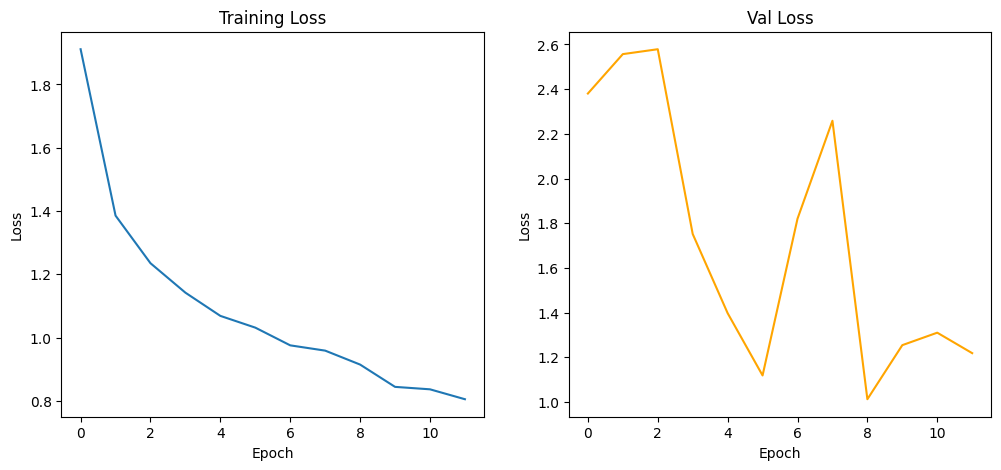

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## **9. Evaluation**

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5833940276766205
Test accuracy:  0.5764192139737991


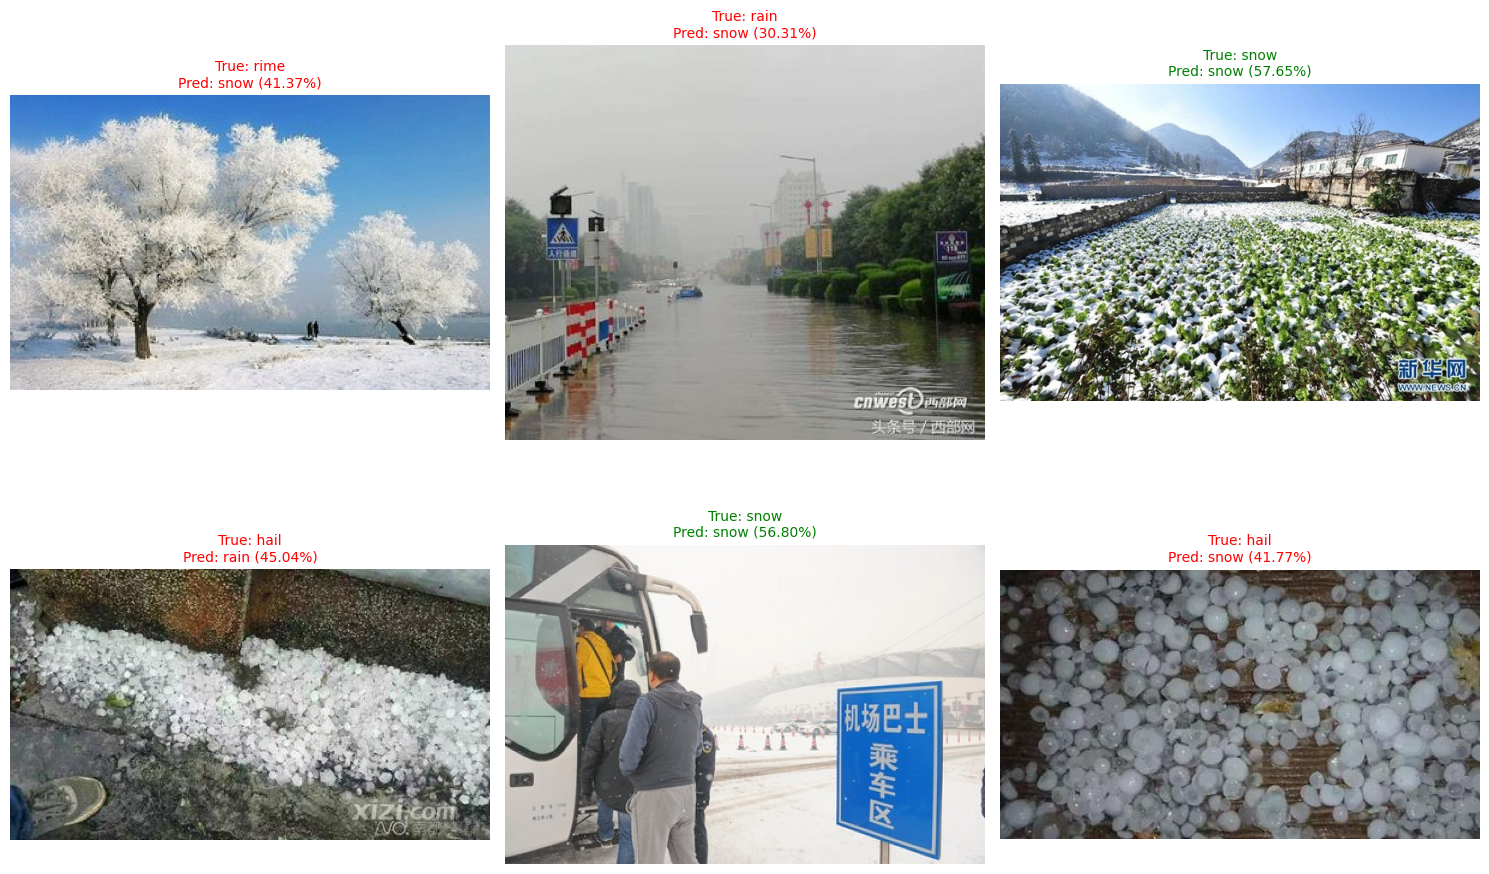

In [ ]:
def predict_sample(model, img_path, transform, device, classes):
    """Predict class for a single image and return prediction details."""
    model.eval()
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred_class = output.argmax(dim=1).item()
        pred_prob = probs[0, pred_class].item()
    return classes[pred_class], pred_prob, img, probs[0].cpu().numpy()

# Test inference on random samples from test set
num_samples = 6
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
for idx, sample_idx in enumerate(sample_indices):
    img_path = X_test[sample_idx]
    true_label = classes[y_test[sample_idx]]

    pred_class, pred_prob, img, probs = predict_sample(model, img_path, transform, device, classes)

    axes[idx].imshow(img)
    color = 'green' if true_label == pred_class else 'red'
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_class} ({pred_prob:.2%})', fontsize=10, color=color)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()